In [1]:
# General libraries
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

# Scikit Learn libraries
from sklearn.model_selection import train_test_split

# Utils functions
from utils.utils import compare_models, plot_score_dist, compare_confidence_intervals, five_two, read_datasets

In [2]:
x_train, x_test, y_train, y_test = read_datasets(
    'x_train.csv',
    'x_test.csv',
    'y_train.csv',
    'y_test.csv'
)

In [3]:
def load_model(model):
    models_folder = '../models/'
    return joblib.load(models_folder + model + '_model.joblib')

In [4]:
#1000 to 10.000 did not show significative differences
#size 2270 based on the paper: https://www.econstor.eu/bitstream/10419/67820/1/587473266.pdf
random_state_list = list(np.random.randint(low = 1,high=5000,size=2270))

## Linear Regression VS SVR

In [5]:
five_two(
    reg1=load_model('lr'),
    reg2=load_model('svr'),
    X=x_train.copy(),
    y=y_train.copy(),
    metric='default'
    )

Fold  1 score difference = 0.003335
Fold  2 score difference = -0.132111
Fold  1 score difference = -0.112742
Fold  2 score difference = -0.129562
Fold  1 score difference = -0.235012
Fold  2 score difference = -0.104680
Fold  1 score difference = -0.029242
Fold  2 score difference = -0.096055
Fold  1 score difference = -0.172113
Fold  2 score difference = -0.105608
Regression 1 mean score and stdev : 0.044218 + 0.075158
Regression 2 mean score and stdev : 0.155597 + 0.047330
Score difference mean + stdev : -0.111379 + 0.063210
t_value for the current test is 0.049986


mean_score_1 0.006205040814996036, std 0.11170797420794602
mean_score_2 0.09142817328233625, std 0.09710107060271515
Ttest_relResult(statistic=-54.32574094676967, pvalue=0.0)
P value menor ou igual a 0.05


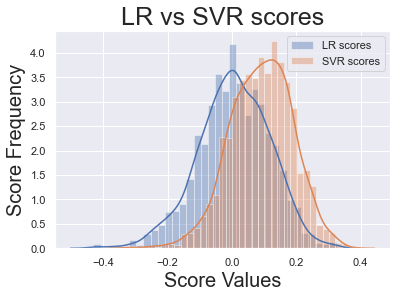

In [6]:
reg1_scores, reg2_scores = compare_models(
    reg1=load_model('lr'),
    reg2=load_model('svr'),
    X=x_test.copy(),
    y=y_test.copy(),
    random_state_list = random_state_list
)


plot_score_dist(reg1_scores, reg2_scores, 'LR', 'SVR')

In [7]:
compare_confidence_intervals(
    reg1_scores, reg2_scores,
    lower=2.5, upper=97.5
)

-0.2271778609322047
0.2065180364876448
-0.10867950520790737
0.2671631854839523


## Linear Regression VS XGBoost

In [8]:
five_two(
    reg1=load_model('lr'),
    reg2=load_model('xgboost'),
    X=x_train.copy(),
    y=y_train.copy(),
    metric='default'
    )

[20:35:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/gbm/gbtree.cc:82: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
Fold  1 score difference = -0.039021
[20:35:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/gbm/gbtree.cc:82: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
Fold  2 score difference = -0.146097
[20:35:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/gbm/gbtree.cc:82: DANGER AHEAD: You hav

mean_score_1 0.006205040814996036, std 0.11170797420794602
mean_score_2 0.23541556388301269, std 0.07328022290275717
Ttest_relResult(statistic=-132.79571026086182, pvalue=0.0)
P value menor ou igual a 0.05


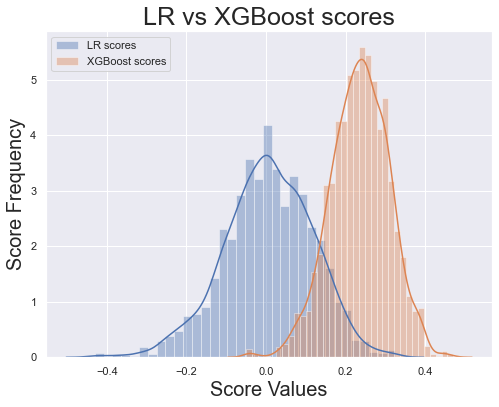

In [9]:
reg1_scores, reg2_scores = compare_models(
    reg1=load_model('lr'),
    reg2=load_model('xgboost'),
    X=x_test.copy(),
    y=y_test.copy(),
    random_state_list = random_state_list
)

plot_score_dist(reg1_scores, reg2_scores, 'LR', 'XGBoost')

In [10]:
compare_confidence_intervals(
    reg1_scores, reg2_scores,
    lower=2.5, upper=97.5
)

-0.2271778609322047
0.2065180364876448
0.08322871366594746
0.3775880408382689


## SVR VS XGboost

In [11]:
five_two(
    reg1=load_model('svr'),
    reg2=load_model('xgboost'),
    X=x_train.copy(),
    y=y_train.copy(),
    metric='default'
    )

[20:35:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/gbm/gbtree.cc:82: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
Fold  1 score difference = -0.042356
[20:35:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/gbm/gbtree.cc:82: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
Fold  2 score difference = -0.013986
[20:35:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/gbm/gbtree.cc:82: DANGER AHEAD: You hav

mean_score_1 0.09142817328233625, std 0.09710107060271515
mean_score_2 0.23541556388301269, std 0.07328022290275717
Ttest_relResult(statistic=-124.93519793279674, pvalue=0.0)
P value menor ou igual a 0.05


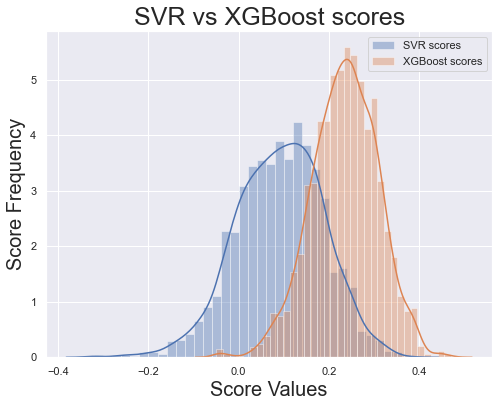

In [12]:
reg1_scores, reg2_scores = compare_models(
    reg1=load_model('svr'),
    reg2=load_model('xgboost'),
    X=x_test.copy(),
    y=y_test.copy(),
    random_state_list = random_state_list
)

plot_score_dist(reg1_scores, reg2_scores, 'SVR', 'XGBoost')

In [13]:
compare_confidence_intervals(
    reg1_scores, reg2_scores,
    lower=2.5, upper=97.5
)

-0.10867950520790737
0.2671631854839523
0.08322871366594746
0.3775880408382689


mean_score_1 -0.8404403669409085, std 0.19669191224652555
mean_score_2 -0.5487736013651794, std 0.14843942587994402
Ttest_relResult(statistic=-124.93519793279675, pvalue=0.0)
P value menor ou igual a 0.05


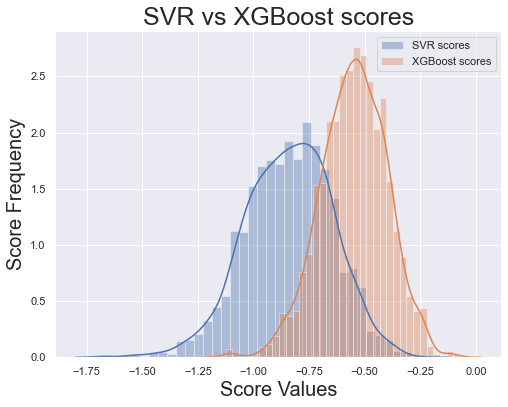

In [14]:
reg1_scores, reg2_scores = compare_models(
    reg1=load_model('svr'),
    reg2=load_model('xgboost'),
    X=x_test.copy(),
    y=y_test.copy(),
    metric="adj_r2",
    random_state_list = random_state_list
)

plot_score_dist(reg1_scores, reg2_scores, 'SVR', 'XGBoost')

In [15]:
compare_confidence_intervals(
    reg1_scores, reg2_scores,
    lower=2.5, upper=97.5
)

-1.2457866900365304
-0.48446431658378897
-0.8570495287279526
-0.2607831993276091


# XGBoost vs Neural Network

In [16]:
five_two(
    reg1=load_model('xgboost'),
    reg2=load_model('mlpRegressor'),
    X=x_train.copy(),
    y=y_train.copy(),
    metric='default'
    )

[20:36:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/gbm/gbtree.cc:82: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
Fold  1 score difference = 0.022058
[20:36:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/gbm/gbtree.cc:82: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
Fold  2 score difference = 0.019843
[20:36:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/gbm/gbtree.cc:82: DANGER AHEAD: You have 

mean_score_1 0.23541556388301269, std 0.07328022290275717
mean_score_2 0.18473287920122097, std 0.07247035186130639
Ttest_relResult(statistic=64.03059640112664, pvalue=0.0)
P value menor ou igual a 0.05


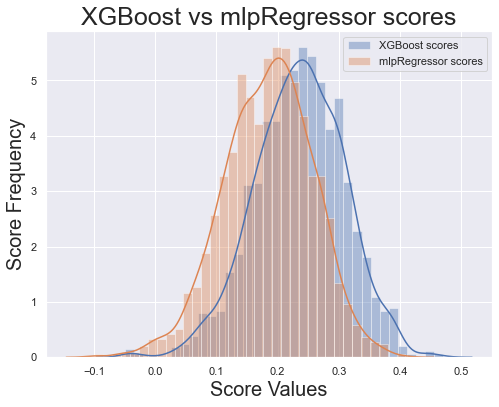

In [17]:
reg1_scores, reg2_scores = compare_models(
    reg1=load_model('xgboost'),
    reg2=load_model('mlpRegressor'),
    X=x_test.copy(),
    y=y_test.copy(),
    random_state_list = random_state_list
)

plot_score_dist(reg1_scores, reg2_scores, 'XGBoost', 'mlpRegressor')

In [18]:
compare_confidence_intervals(
    reg1_scores, reg2_scores,
    lower=2.5, upper=97.5
)

0.08322871366594746
0.3775880408382689
0.03983194915965735
0.3167995874048741
